# Notebook showing use of Zygote's autodiff package

In [1]:
using Zygote
using Plots
using Statistics

In [3]:
a=9
b=8
f(x,a,b) = a*x + b
loss(yTrue,yPred) = sqrt((yTrue-yPred)^2)
gradient(f,randn(1)[1],3,4)

(3.0, 0.5255744791904995, 1.0)

In [4]:
d =3
e = 2
function twoSteps(x,a,b,yTrue)
	out = f(x,a,b)
	out2 = f(out,a,b)
	return loss(yTrue, out2)
end
gradient(twoSteps,randn(1)[1],3,4,4)

(8.999999999999998, -0.8521615588459646, 3.9999999999999996, -0.9999999999999999)

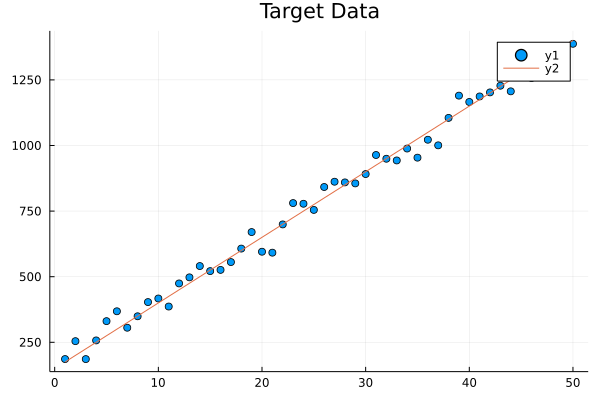

In [17]:
function oneStep(x,a,b,yTrue)
	out = f(x,a,b)
	lossVal = loss(yTrue,out)
	return lossVal
end

batches = rand(5)
lengthLine = 50
target_a =25
target_b =150
noiseFac =40

line = ones(lengthLine)
for idx in range(1,length=length(line))
    line[idx] = f(idx,target_a,target_b)
end
noisyLine = line .+ randn(length(line))*noiseFac
plot([1:length(noisyLine)],noisyLine,seriestype = :scatter,title="Target Data")
plot!([1:length(noisyLine)],line)

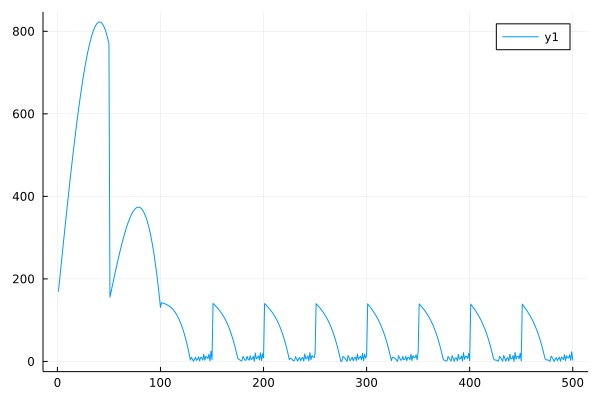

In [7]:
lr = 0.01
epochs = 10
aVals = []
losses = []
a1 = rand(1)[1]
b1 = rand(1)[1]*10
xVals = 1:1:lengthLine
for e in 1:epochs
    for xIdx in 1:lengthLine
        l, grads = withgradient(oneStep,xVals[xIdx],a1,b1,line[xIdx])
        a1 -= grads[2]*lr
        b1 -= grads[3]*lr
        append!(aVals,a1)
        append!(losses,l)
    end
end
plot([1:length(losses)],losses)

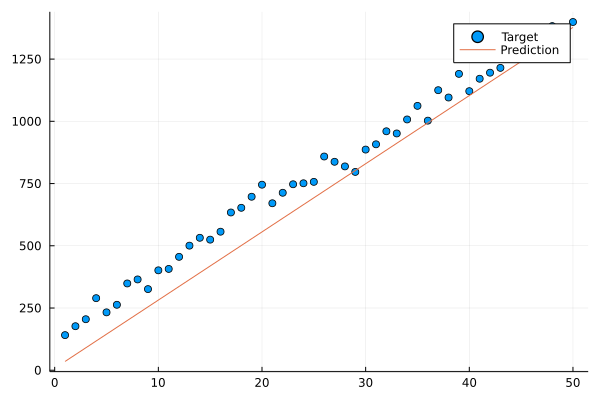

In [8]:
linePred = ones(lengthLine)
for idx in range(1,length=length(line))
    linePred[idx] = f(idx,a1,b1)
end

begin
plot(1:lengthLine,noisyLine,seriestype = :scatter,label="Target")
plot!(1:lengthLine, linePred,label="Prediction")
end

In [9]:
xValsVec = 1:lengthLine
fVec(x,a,b) = x.*a .+b
lossVec(yTrue,out) = mean(sqrt.((yTrue.-out).^2))
function oneStepVec(x,a,b,yTrue)
	out = fVec(x,a,b)
	lossVal = lossVec(yTrue,out)
	return lossVal
end

oneStepVec (generic function with 1 method)

In [10]:
function transform(x)
	xStd = std(x)
	xMean = mean(x)
	xTransform = (x.-xMean) ./ xStd
	return xTransform, xStd, xMean
end

function invTransform(x,xStd,xMean)
	round.((x.*xStd).+xMean,digits=8)
end

invTransform (generic function with 1 method)

In [11]:
xValsVecTr, xStd, xMean = transform(xValsVec)
lineTr, lineStd, lineMean = transform(line)

println("Line and$(line == invTransform(lineTr, lineStd, lineMean))")

Line andtrue


In [12]:
function runDesc(lrVec,epochsVec)
    lossesVec = []
    a2 = randn(1)[1]
    b2 = randn(1)[1]
    for e in 1:epochsVec
        lVec, gradsVec = withgradient(oneStepVec,xValsVecTr,a2,b2,lineTr)
        a2 -= gradsVec[2]*lrVec
        b2 -= gradsVec[3]*lrVec
        append!(lossesVec,lVec)
    end
    return lossesVec, a2,b2
end

runDesc (generic function with 1 method)

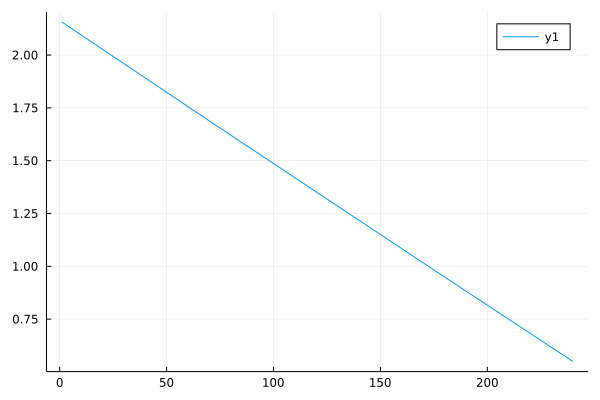

In [13]:
lossesVec2, aPred,bPred = runDesc(1e-2, 240)
plot(1:length(lossesVec2),lossesVec2)

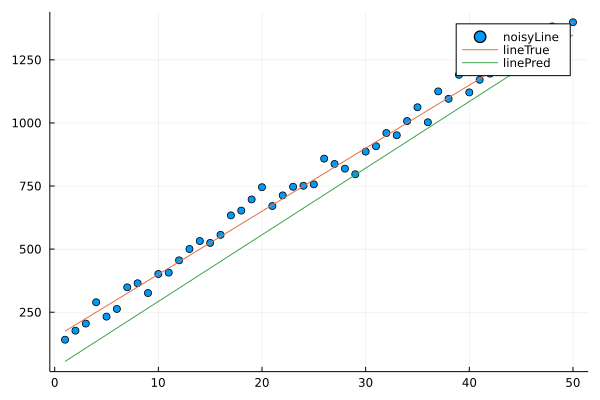

In [14]:
linePredVec = fVec(xValsVecTr, aPred,bPred)
lineTrue = fVec(xValsVec, target_a,target_b)

plot(1:lengthLine,noisyLine,seriestype = :scatter,label="noisyLine")
plot!(1:lengthLine, lineTrue,label="lineTrue")
plot!(1:lengthLine, invTransform(linePredVec,lineMean,lineStd),label="linePred")


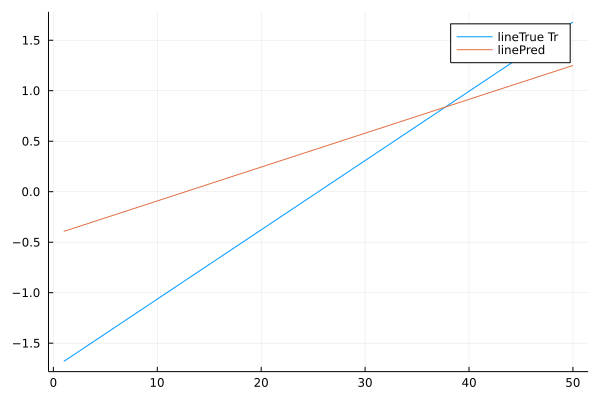

In [15]:
plot(1:lengthLine,noisyLine,seriestype = :scatter,label="noisyLine")
plot(1:lengthLine, transform(lineTrue),label="lineTrue Tr")
plot!(1:lengthLine, linePredVec,label="linePred")


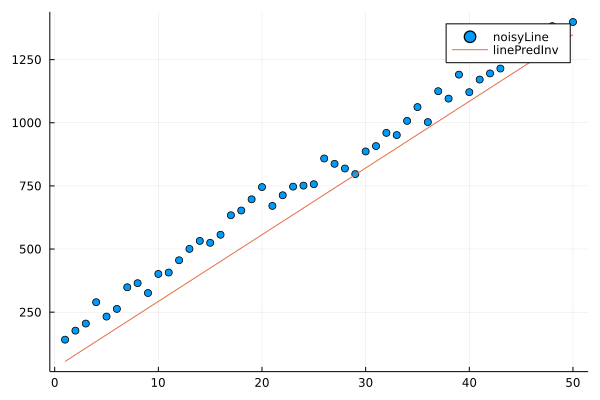

In [16]:
linePredInv = invTransform(linePredVec,lineMean,lineStd)

plot(1:lengthLine,noisyLine,seriestype = :scatter,label="noisyLine")
plot!(1:lengthLine, linePredInv,label="linePredInv")